In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

### Parameters for all Simulations

In [2]:
# functional parameters 
function affect!(integrator) # jump process
      n = rand(1:integrator.p.N)
      n2 = rand(1:integrator.p.N)
      integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
rate(u,p,t) = p.β*p.N # jump rate

function rate_index(u, p, t, index)
   return p.β
end
affect_index!(integrator, index) = (integrator.u[index] =
    max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))


# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 100, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 1000, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility, 
    affect! = affect!, # jump process 
    rate = rate,
    affect_index! = affect_index!,
    ρ_max = 2.0,
    rate_index = rate_index,
    x_iv_test = rand(iv_dist, N))

#3 (generic function with 2 methods)

# Same Initial Condition

## In order to compare properly, I add `x_iv_test` in `params` and just use it as `x_iv`. 

### Generator Functions for Problem Objects

### Many Jumps

In [3]:
function generate_many_jump_prob(p, rate_index, affect_index!)
#     x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, p.x_iv_test, (0.0, p.t[end]), p)
    jumps = [ConstantRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((),(jumps),nothing,nothing))
    return jump_prob
end

function generate_many_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        # g calculated w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_many_ensemble_prob (generic function with 1 method)

### Single Jumps

In [4]:
function generate_jump_prob(p)
#     x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, p.x_iv_test, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p);
    function write_moments(sol, i) 
        resize!(sol.t, 0); resize!(sol.u, 0); append!(sol.t, sol.prob.p.t); append!(sol.u, sol.prob.p.moments)
        return (sol, false)
    end
    function calculate_moments(u, t, integrator) 
        # g computed w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end
    
p = params();

### Ensemble Aggregates

Run several simulations, and track the mean of their moments over time.

### Many Jumps

In [5]:
jump_prob = generate_many_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_many_ensemble_prob(jump_prob)

sim_many = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), 
    trajectories = p.trajectories, callback = cb, save_everystep = false)
summ_many = EnsembleSummary(sim_many);

### Single Jump

In [6]:
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), 
    trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim);

### Many vs Single

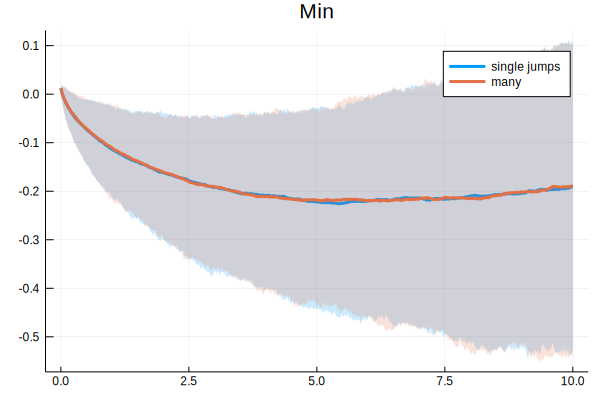

In [7]:
p1 = plot(summ, idxs = [1], title = "Min", label = "single jumps",legend = true)
plot!(summ_many, idxs = [1], title = "Min", label = "many",legend = true)

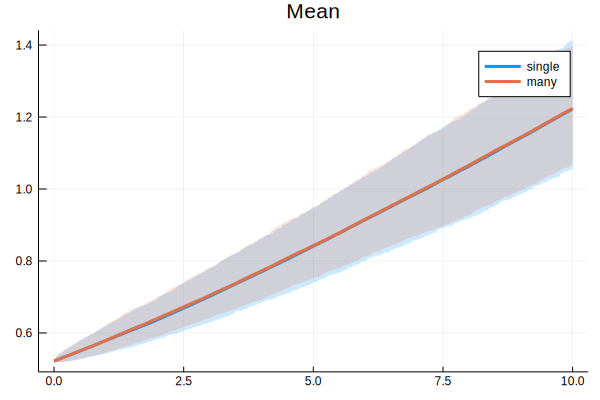

In [8]:
p2 = plot(summ, idxs = [2], title = "Mean", label = "single", legend = true)
plot!(summ_many, idxs = [2], title = "Mean", label = "many",legend = true)

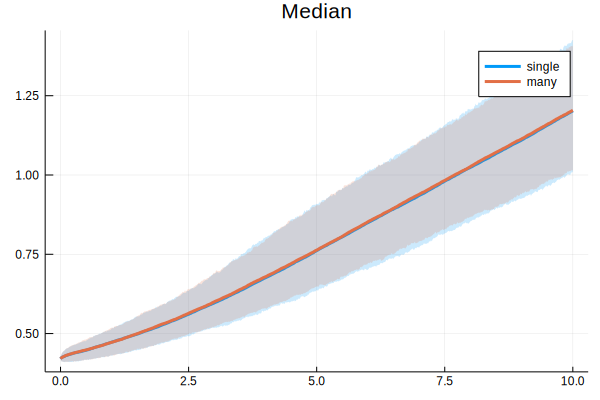

In [9]:
p3 = plot(summ, idxs = [3], title = "Median",label = "single",legend = true)
plot!(summ_many, idxs = [3], title = "Median", label = "many",legend = true)

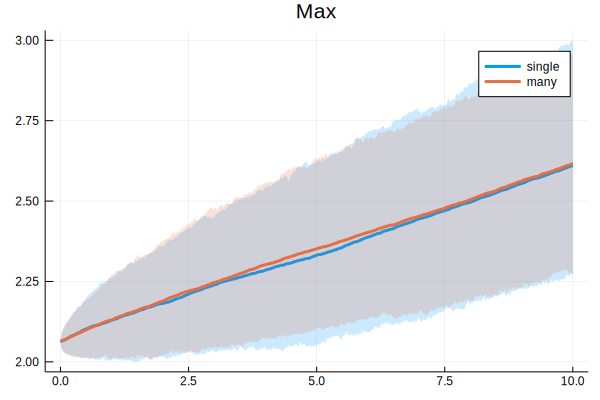

In [10]:
p4 = plot(summ, idxs = [4], title = "Max", label = "single",legend = true)
plot!(summ_many, idxs = [4], title = "Max", label = "many",legend = true)

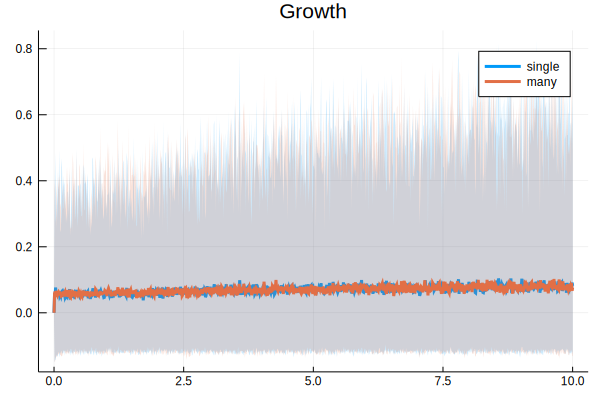

In [11]:
p5 = plot(summ, idxs = [5], title = "Growth", label = "single",legend = true)
plot!(summ_many, idxs = [5], title = "Growth", label = "many",legend = true)